In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.optimize import minimize

In [2]:
from modules import models
from modules import experiment as exp
from modules import plots, fitting, evaluation, utils

In [3]:
from importlib import reload
_ = reload(models)
_ = reload(exp)
_ = reload(plots)
_ = reload(evaluation)
_ = reload(fitting)
_ = reload(utils)

In [4]:
shifted_obj_lists = []
fitted_model_lists = []
p_fractions = []

for obj in exp.all_objects:
    print('=' * 15)
    print(obj.name)
    print('=' * 15)

    obj_models = [
        models.BasicHadronicModelSED.at_z(obj.z),
        models.LogparabolaThroughEblSED.for_object(obj),
    ]
    exp_E_varying_configs = [
        # fitting.ExpSedEnergyVaryingConfig.for_object(obj, default=True, fix=['Fermi']),
        fitting.ExpSedEnergyVaryingConfig.for_object(obj, default=True),
        fitting.ExpSedEnergyVaryingConfig.for_object(obj, default=False),
    ]

    shifted_objs = []

    for model, exp_E_varying in zip(obj_models, exp_E_varying_configs):
        model_params, E_factors = fitting.fit_model_to_object(
            obj, model, exp_E_varying=exp_E_varying
        )
        print(f'model params: {", ".join(str(p) for p in model_params)}')
        model.set_parameters(*model_params)
        shifted_objs.append(obj.with_E_factors(*E_factors))

    aw = evaluation.compare_models_for_objects(
        shifted_objs, obj_models, exp_E_varying_configs
    )

    prob_ratio = aw[0] / aw[1]
    p_fractions.append(prob_ratio)
    print(f'\nthe best model is {prob_ratio} times more probable given the data than the second\n')

    shifted_obj_lists.append(shifted_objs)
    fitted_model_lists.append(obj_models)


1ES1218+304
optimizing model...
optimization result: Optimization terminated successfully.
model params: 1.0799490572284633
optimizing model...
optimization result: Optimization terminated successfully.
model params: 1.0828910112318478e-11, -0.03762579752880052, 0.058292853869066824
Akaike weights:

	Model	|	Object	|	Weight
	Logparabola source + EBL absorption	|	1ES1218+304 (shifts: 1.0, 1.0)	|	1.000000
	Basic hadronic cascade model	|	1ES1218+304 (shifts: 0.8500000176412508, 1.2803761891880456)	|	0.000000

the best model is 8.095361030655895e+51 times more probable given the data than the second

1ES1101-232
optimizing model...
optimization result: Optimization terminated successfully.
model params: 0.15420495191696523
optimizing model...
optimization result: Optimization terminated successfully.
model params: 3.728083502437495e-12, -0.4278817532037772, -0.013934010175695767
Akaike weights:

	Model	|	Object	|	Weight
	Logparabola source + EBL absorption	|	1ES1101-232 (shifts: 1.0, 1.0)	

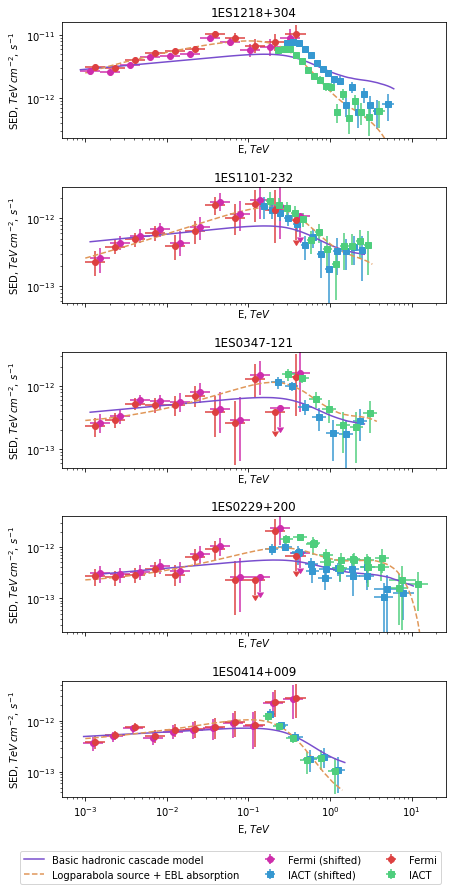

In [9]:
n_plots = len(exp.all_objects)

fig, axes = plt.subplots(
    nrows=n_plots + 1, ncols=1, sharex=True, figsize=(6.5, n_plots*2.5),
    gridspec_kw={'height_ratios': [1] * n_plots + [0.2]},
)

for ax, shifted_objs, obj_models in zip(axes, shifted_obj_lists, fitted_model_lists):
    for obj_shifted, model in zip(shifted_objs, obj_models):
        obj_shifted.plot(ax, adjust_ylim_with_pad=0.05)
        model.plot(ax, *utils.enlarge_log_interval(obj_shifted.E_min, obj_shifted.E_max, pad=0))
    ax.set_title(obj_shifted.name)

ax.tick_params(axis='x', labelbottom=True)

legend_ax = axes[-1]
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, labels, ncol=3)
legend_ax.set_axis_off()

plt.tight_layout()

fig.savefig('./pics/objectwise-fits.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
print('name\tfermi shift\tiact shift\tP frac')

def E_factor_to_percents(E_f):
    return f'${100 * (E_f - 1):.2f} \%$'

sep = '  &  '
for shifted_objs, obj_models, p_frac in zip(shifted_obj_lists, fitted_model_lists, p_fractions):
    print(
        shifted_objs[0].name + sep
        + E_factor_to_percents(shifted_objs[0].seds[0].E_factor) + sep
        + E_factor_to_percents(shifted_objs[0].seds[1].E_factor) + sep
        + f'{p_frac:.1e}' + ' \\\\'
    )

name	fermi shift	iact shift	P frac
1ES1218+304  &  $-15.00 \%$  &  $28.04 \%$  &  8.1e+51 \\
1ES1101-232  &  $13.62 \%$  &  $-16.37 \%$  &  2.2e+03 \\
1ES0347-121  &  $14.16 \%$  &  $-25.10 \%$  &  2.6e+00 \\
1ES0229+200  &  $15.00 \%$  &  $-34.13 \%$  &  1.4e+01 \\
1ES0414+009  &  $-5.68 \%$  &  $6.94 \%$  &  4.1e+01 \\
